In [79]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [80]:
def set_input_tensor(interpreter, image):
  tensor_index = interpreter.get_input_details()[0]['index']
  print(f'index of the input tensor: {tensor_index}\n\n')

  # return input tensor base on its index
  input_tensor = interpreter.tensor(tensor_index)()[0]


  # before assigning the image to input tensor
  plt.subplots(nrows=1, ncols=2)
  plt.subplot(121)
  plt.imshow(input_tensor)
  plt.title('before')

  input_tensor[:, :] = image

  # after assigning the image to input tensor
  plt.subplot(122)
  plt.imshow(input_tensor)
  plt.title('after')
  

In [81]:
def unset_input_tensor(interpreter):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]

    input_tensor[:, :] = np.zeros(shape=(224,224,3))


In [82]:
def classify_image(interpreter, image):

    # models makes a prediction and store to output tensor
    interpreter.invoke()

    output_details = interpreter.get_output_details()[0]
    print(f'details about the output tensor:\n {output_details}\n\n')

    scores = interpreter.get_tensor(output_details['index'])[0]
    print(f'predicted class label score: {np.max(np.unique(scores))}')

    # dequantized the scores
    scale, zero_point = output_details['quantization']
    scores_dequantized = scale * (scores - zero_point)

    dequantized_max_score = np.max(np.unique(scores_dequantized))
    print(f'predicted class label probability: {dequantized_max_score}')


    max_score_index = np.where(scores_dequantized == np.max(np.unique(scores_dequantized)))[0][0]
    print(f'predicted class label id: {max_score_index}\n\n')

    return max_score_index, dequantized_max_score
    

In [83]:
def load_labels(path):
  with open(path, 'r') as f:
    return [line.strip() for i, line in enumerate(f.readlines())]

model loaded successfully
details about the input tensor: 
 [{'name': 'serving_default_sequential_7_input:0', 'index': 181, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.007843137718737125, 127), 'quantization_parameters': {'scales': array([0.00784314], dtype=float32), 'zero_points': array([127]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

number of input tensors: 1

details of the 1st input tensor: 
 {'name': 'serving_default_sequential_7_input:0', 'index': 181, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.007843137718737125, 127), 'quantization_parameters': {'scales': array([0.00784314], dtype=float32), 'zero_points': array([127]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


image width: 224
image height: 224


original size: (500, 500)
new size: (224, 224)


index of the input t

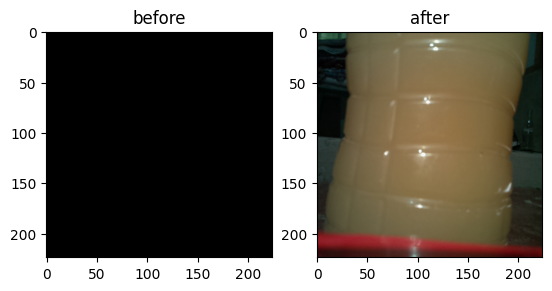

In [84]:
label_path = '../model/labels.txt'
model_path = '../model/model.tflite'

labels = load_labels(label_path)

# alternative : from tflite_runtime.interpreter import Interpreter
interpreter = tf.lite.Interpreter(model_path)
print('model loaded successfully')

# allocate to memory
interpreter.allocate_tensors()

print(f'details about the input tensor: \n {interpreter.get_input_details()}\n')
print(f'number of input tensors: {len(interpreter.get_input_details())}\n')
print(f'details of the 1st input tensor: \n {interpreter.get_input_details()[0]}\n\n')

_, height, width, _ = interpreter.get_input_details()[0]['shape']
print(f'image width: {width}\nimage height: {height}\n\n')


# read image
image_path='../images/sample/test-1.jpg'

img = Image.open(image_path).convert('RGB')
print(f'original size: {img.size}')

img = img.resize((224, 224))
print(f'new size: {img.size}\n\n')

set_input_tensor(interpreter, img)

label_id, prob = classify_image(interpreter, img)

class_label = labels[label_id]

accuracy = np.round(prob * 100, 2)

print(f'image label: {class_label}\naccuracy: {accuracy}')

unset_input_tensor(interpreter)